In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

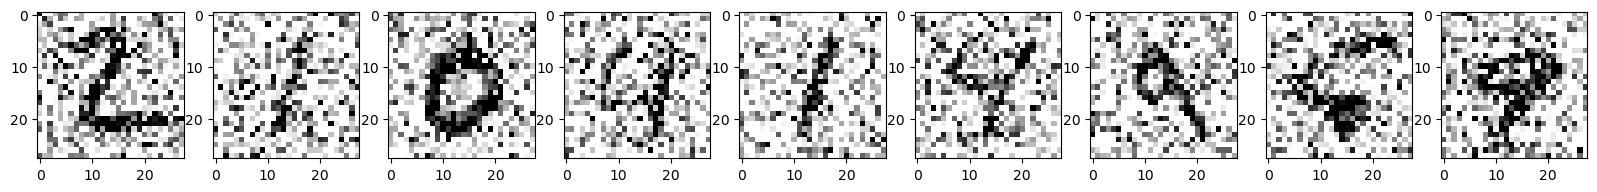

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32') / 255.0 
X_test = X_test.astype('float32') / 255.0 
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

noise_factor = 0.5 
for i in range(100):
    X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
    
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

plt.figure(figsize=(20, 3))
for i in range(1, 10):
    ax = plt.subplot(1, 9, i)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='binary')
plt.show()

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 
model.add(MaxPooling2D((2, 2), padding='same'))
 
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

checkpointer = tf.keras.callbacks.ModelCheckpoint('denoise_mnist_model.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='logs')
]

model.fit(X_train_noisy, X_train, epochs=100, batch_size=128, shuffle=True, validation_data=(X_test_noisy, X_test), callbacks=[checkpointer, callbacks])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         2312      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 8)          0

In [4]:
model.evaluate(X_test_noisy, X_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0175


0.017466289922595024

313/313 [==============================] - 2s 7ms/step


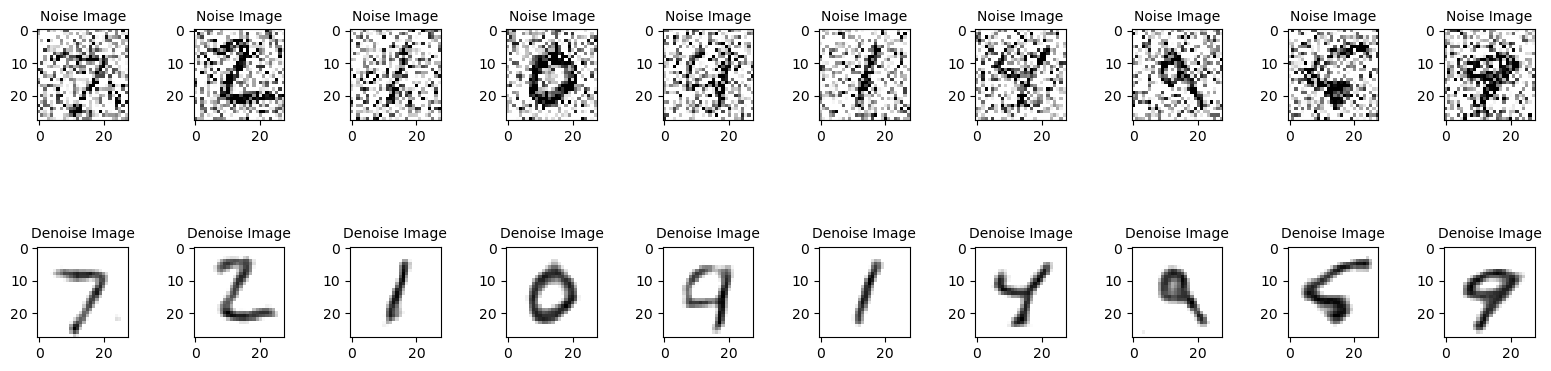

In [5]:
no_noise_img = model.predict(X_test_noisy)

plt.figure(figsize=(40, 4))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='binary')
    plt.title('Noise Image', fontsize=10)
    ax = plt.subplot(3, 20, 40 + i + 1)
    plt.imshow(no_noise_img[i].reshape(28, 28), cmap='binary')
    plt.title('Denoise Image', fontsize=10)
plt.show()